# Part 2 
In this notebooks, we test the embedings of a pretrained FaceNet models in an open set face recognition problem. The dataset used in mix of celebrities and unknown people.

In [ ]:
# Libraries
# OS 
import os


# Data wrangling
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine
import mtcnn
import cv2
from tensorflow import  keras

# Plot
import  matplotlib.pyplot as plt
import matplotlib.patches as patches




## Images extracting, face cropping and face resizing
The pretrained facenet model loaded was fitted on face pictures of 224x224x3 normalized pixels. To have the same inputs as this network we :
- Extract the picture of our dataset
- Crop the faces helped by a `MTCNN` detector
- Resize those faces
- Noramalize the final pictures

In [144]:
def create_correspondance_df(path_to_pictures):
    """
    Creates a correspondance dataframe (person, image_name) for a given dataset  
    args :
    path_to_pictures (str) : Path to folder where the pictures are located
    returns :
    correspondance_df (pd.DataFrame) : The DataFrame with correspondances
    """
    matrix = []
    all_identities  = os.listdir(path_to_pictures)
    cat = 0
    for identity in all_identities:
        for picture in os.listdir(path_to_pictures + "/" + identity):
            matrix.append((identity, picture,str(cat)))
    cat += 1

    correspondance_df = pd.DataFrame(matrix,columns = ("id", "face","label"))
    return(correspondance_df)


In [145]:
path_to_pictures = 'data/celebrity'
correspondance_df = create_correspondance_df(path_to_pictures)
detector= mtcnn.MTCNN()
list_IDs = path_to_pictures + "/" + correspondance_df.id + "/" + correspondance_df.face
labels = correspondance_df.id
all_pictures = []
width, height = 160, 160
for i in range( correspondance_df.shape[0]):
    img_path = list_IDs[i]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    try:
        face_x, face_y, face_width, face_height  = detector.detect_faces(img)[0]['box']
        crop = img[face_y:face_y+face_height, face_x:face_x+face_width]
        img = cv2.resize(crop, (width,width))
    except:
        img = cv2.resize(img, (width,width))
    img = np.expand_dims(img, axis=0)
    norm = (img - 127.5) / 128
    all_pictures.append((img,norm, labels[i]))
    normed_pictures = pd.DataFrame(all_pictures,columns= ["not_normed_picture","picture","id"])


## Test set and identification set separation
To do face recognition, we need pictures of identities to compare to our test set. Normaly the more picture in our identification database we have, the more we have chance to right identify the person to the right identity. Here we will try different `n_pictures_by_identities` in our identification dataset.  

In [146]:
def plot_sample( picture_df, x = 3, y = 3):
    fig, axs = plt.subplots(x,y,figsize = (x*3,y*3))
    sample = picture_df.sample(n=x*y, replace=False)
    index = 0
    for i in range(x):
        for j in range(y):
            RGB_img = sample.iloc[index,0][0]
            id = sample.iloc[index,2]
            axs[i][j].imshow(RGB_img)
            axs[i][j].set_title(id)
            index += 1
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle("Sample of normalized pictures of the identification set")
    plt.show()

In [147]:
np.random.seed(1)
n_pictures_by_identities = 3 #We start with 3 pictures by identites
replace = False  
fn = lambda obj: obj.loc[np.random.choice(obj.index, n_pictures_by_identities, replace),:]
identification_set = normed_pictures.groupby('id', as_index=False).apply(fn).reset_index()
identification_set = identification_set[identification_set['id'] != "unknown"].reset_index().drop("index", axis = 1)
test_set = normed_pictures[normed_pictures.index.isin(identification_set['level_1']) == False].reset_index().drop("index",axis = 1)
identification_set.drop(['level_0','level_1'],axis = 1 ,inplace =True)


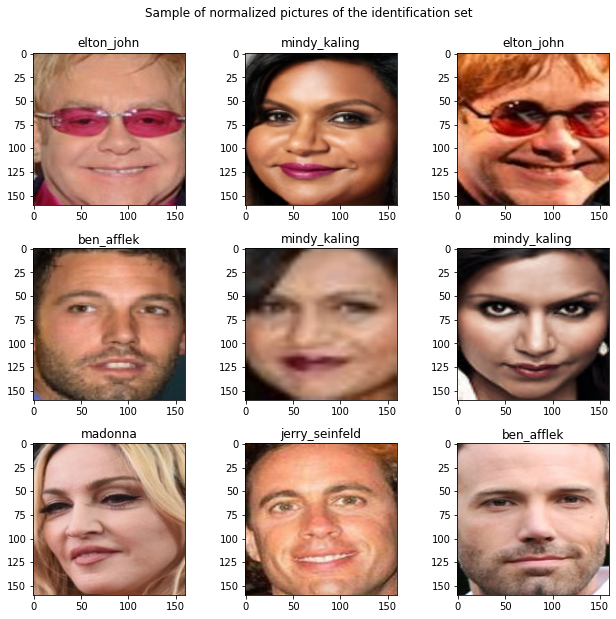

In [149]:
plot_sample(identification_set)

## Model 
The model loaded is returns for an input image its vector embedding. We will pre compute the embedding for all faces (test_set and identification set) in order to not recompute them. 

In [ ]:
model = keras.models.load_model('models/facenet/model/facenet_keras.h5')
model.load_weights('models/facenet/weights/facenet_keras_weights.h5')

In [151]:
test_set["embeddings"] = test_set["picture"].apply(lambda x: model.predict(x))
identification_set["embeddings"] = identification_set["picture"].apply(lambda x: model.predict(x))
print("Example of the embedding of a picture of " + identification_set['id'][0] + " : " + str(identification_set['embeddings'][0]))

Example of the embedding of a picture of ben_afflek : [[-0.37419534  0.71474683  0.07123049 -1.3229885  -0.30196363 -1.0996963
   1.3322805  -0.10079093  0.31315324 -0.20723765  0.4616987  -0.5351501
   0.05569901 -0.72987616  0.8998841   0.2051362  -2.2888587   0.23434912
   0.08990205 -0.2646527   1.1744356  -0.15045416 -0.15785024 -0.7635442
  -0.5788746  -1.23527     1.1495608  -0.48442453 -1.8122578   0.5171756
  -1.5292075   1.1830032   2.1974516  -0.01212995 -1.1628526   0.2692497
  -1.7165606  -0.43086952 -1.1310058   0.09102615  0.5617545  -0.43524513
  -1.0452373  -0.5107519  -0.5772655  -0.7993305  -0.89406407  0.45017254
  -0.42898855  0.33451784 -0.48065722 -0.16289322  0.6169112  -0.3772949
   1.162308   -1.1211668  -1.3528862   0.372127   -0.8623396  -1.1107242
  -1.1725093  -0.83609134 -1.9096205  -1.3864763   0.79377055 -1.7684435
  -0.3897719   0.06906566 -0.11026692 -0.6789879  -0.9124006  -0.31844658
   0.38647133 -1.0084846  -1.9334961  -0.27145126 -0.43978807 -0.8

## Similarity measure 
To measure similarity between embeddings we the famous cosine similarity : 
${\displaystyle {\text{similarity(A,B)}}=\cos(\theta )={\mathbf {A} \cdot \mathbf {B}  \over \|\mathbf {A} \|\|\mathbf {B} \|}={\frac {\sum \limits _{i=1}^{n}{A_{i}B_{i}}}{{\sqrt {\sum \limits _{i=1}^{n}{A_{i}^{2}}}}{\sqrt {\sum \limits _{i=1}^{n}{B_{i}^{2}}}}}},}$

To decide if a picture is a specific person or not we will put a `threshold` hyparameter, if the similarity is lower than this one, we will consider that the person is the same.

To do face recognition, we will do this identification step for all identification image in the identification dataset.

In [152]:
def predict(embeding, dataset, identities, threshold = 0.4):
    min = threshold
    label = "unknown"
    x = embeding[0,:]
    for i in range(len(dataset)):
        anchor = dataset[i][0,:] 
        sim = cosine(x, anchor) 
        if sim <= threshold:
            if sim <= min:
                label = identities[i]
    return label


Let's test different thresholds for `n_pictures_by_identities = 3`

Best results achieved for threshold : 0.6
Max accuracy : 0.9649122807017544


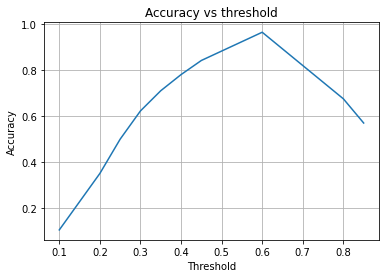

In [153]:
results = []
thresh = [0.1,0.2,0.25,0.3,0.35,0.4,0.45,0.6,0.8,0.85]
for t in thresh:
  test_set["pred"] = None
  for index in test_set.index:
    test_set["pred"][index] = predict(test_set.loc[index,"embeddings"],list(identification_set['embeddings']),list(identification_set['id']), threshold= t)
  accuracy = np.sum(test_set["pred"] == test_set["id"])/test_set.shape[0]
  results.append((t,accuracy))

results = np.array(results)
plt.plot(results[:,0],results[:,1])
plt.title("Accuracy vs threshold")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.grid()
best = results[np.argmax(results[:,1])]
print("Best results achieved for threshold : " + str(best[0]))
print("Max accuracy : " + str(best[1]))  

Lets look the confusion matrix for this threshold.

In [154]:
t = 0.6
test_set["pred"] = None
for index in test_set.index:
  test_set["pred"][index] = predict(test_set.loc[index,"embeddings"],list(identification_set['embeddings']),list(identification_set['id']), threshold= t)


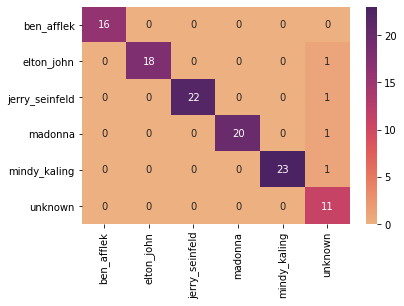

In [155]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels = np.unique(test_set["id"])
m = confusion_matrix(test_set["id"],test_set["pred"])
m =pd.DataFrame(m,index =labels,columns= labels)
sns.heatmap(m, cmap= "flare" , annot = True)

As we can see, the missclassifications of the "model" are overall unknown over the other classes. Let see an example of missclassification.

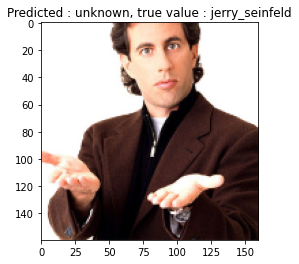

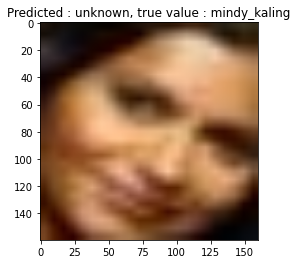

In [156]:
bad_indexes = test_set["pred"] != test_set["id"]
neg = test_set[bad_indexes].reset_index()
plt.imshow(neg["not_normed_picture"][0][0])
plt.title("Predicted : " + neg["pred"][0] + ", true value : "+ neg["id"][0] )
plt.show()
plt.imshow(neg["not_normed_picture"][1][0])
plt.title("Predicted : " + neg["pred"][1] + ", true value : "+ neg["id"][1] )

plt.show()

As we can see, the bad examples are surely due to the data : 
- For the first picture, the MTCNN detector did not detect the face accuratly
- The second one is too blury to be understandable  



#### Test for different number of pictures by identity

In [157]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
final_results = []
for n_pictures_by_identities in [1,2,3,4]:
  res = {}
  res["n"] = n_pictures_by_identities
  fn = lambda obj: obj.loc[np.random.choice(obj.index, n_pictures_by_identities, replace),:]
  identification_set = normed_pictures.groupby('id', as_index=False).apply(fn).reset_index()
  identification_set = identification_set[identification_set['id'] != "unknown"].reset_index().drop("index", axis = 1)
  test_set = normed_pictures[normed_pictures.index.isin(identification_set['level_1']) == False].reset_index().drop("index",axis = 1)
  identification_set.drop(['level_0','level_1'],axis = 1 , inplace =True)
  test_set["embeddings"] = test_set["picture"].apply(lambda x: model.predict(x))
  identification_set["embeddings"] = identification_set["picture"].apply(lambda x: model.predict(x))
  results = []
  thresh = [0.1,0.2,0.25,0.3,0.35,0.4,0.45,0.6,0.8,0.85]
  for t in thresh:
    test_set["pred"] = None
    for index in test_set.index:
      test_set["pred"][index] = predict(test_set.loc[index,"embeddings"],list(identification_set['embeddings']),list(identification_set['id']), threshold= t)
    accuracy = np.sum(test_set["pred"] == test_set["id"])/test_set.shape[0]
    results.append((t,accuracy))
  results = np.array(results)
  best = results[np.argmax(results[:,1])]
  res["results"] = results
  res["best"] = best
  t = best[0]
  test_set["pred"] = None
  for index in test_set.index:
    test_set["pred"][index] = predict(test_set.loc[index,"embeddings"],list(identification_set['embeddings']),list(identification_set['id']), threshold= t)

  labels = np.unique(test_set["id"])
  m = confusion_matrix(test_set["id"],test_set["pred"])
  m =pd.DataFrame(m,index =labels,columns= labels)
  res["confusion"] = m
  final_results.append(res)

---------------------------------------------------
Results for 1 pictures by identities.
Best results achieved for threshold : 0.6
Max accuracy : 0.8951612903225806


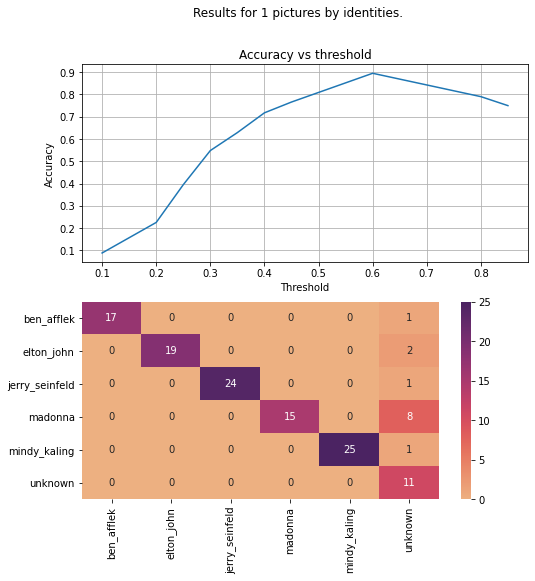

---------------------------------------------------
Results for 2 pictures by identities.
Best results achieved for threshold : 0.6
Max accuracy : 0.9243697478991597


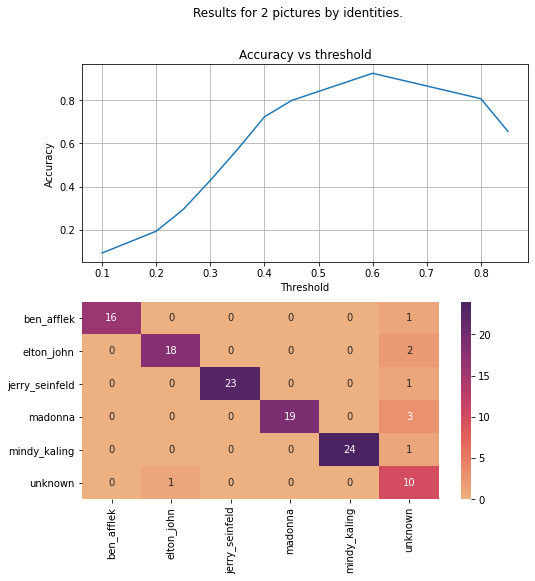

---------------------------------------------------
Results for 3 pictures by identities.
Best results achieved for threshold : 0.6
Max accuracy : 0.956140350877193


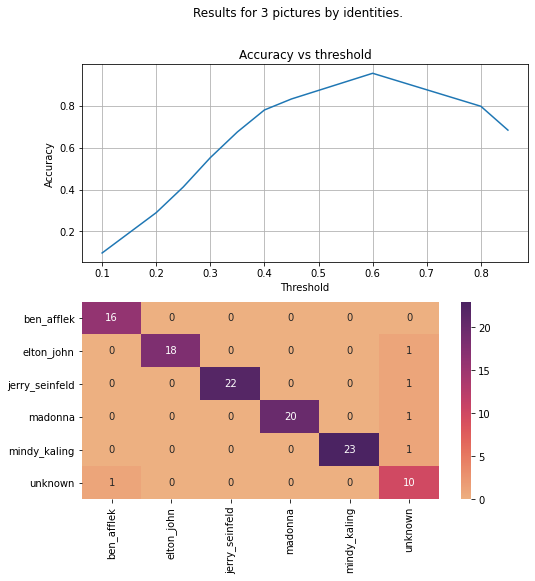

---------------------------------------------------
Results for 4 pictures by identities.
Best results achieved for threshold : 0.6
Max accuracy : 0.9724770642201835


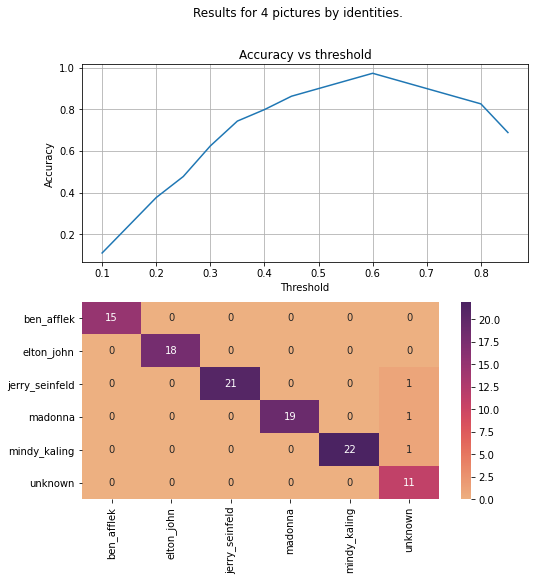

In [158]:
def plot_results(dic):
    fig, ax = plt.subplots(2,1,figsize = (8,8))
    plt.suptitle("Results for " + str(dic['n']) +" pictures by identities." )
    results = dic['results']
    best = results[np.argmax(results[:,1])]
    print("---------------------------------------------------")
    print("Results for " + str(dic['n']) +" pictures by identities.")
    print("Best results achieved for threshold : " + str(best[0]))
    print("Max accuracy : " + str(best[1]))  
    ax[0].plot(results[:,0],results[:,1])
    ax[0].set_title("Accuracy vs threshold")
    ax[0].set_xlabel("Threshold")
    ax[0].set_ylabel("Accuracy")
    ax[0].grid()
    m = dic["confusion"]
    sns.heatmap(m, cmap= "flare" , annot = True,ax = ax[1])
    plt.show()
for res in final_results:
    plot_results(res)

As we can see, 
- One image by identity is a bit few but we obtain almost 90%
- With three or four images we have more than 95% accuracy
Thus face embedings and cosine similarity are a good way to achieve good results in one shot learning (for face recognition)